In [1]:
!pip install roboflow
!pip install torch torchvision torchaudio

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 32.9 MB/s eta 0:00:00


###Dataset from Roboflow

In [2]:
from roboflow import Roboflow
rf = Roboflow(api_key="Enter your API Key here")
project = rf.workspace("luis-humberto-luis-n33hl").project("ai4thrashadd")
version = project.version(1)
dataset = version.download("coco")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to AI4ThrashAdd-1 in coco:: 100%|██████████| 481/481 [00:01<00:00, 371.61it/s]


###Split the dataset into train and test along with their annotations


In [88]:
import os
import shutil
import json

# Define paths
train_folder = "/content/AI4ThrashAdd-1/train"
test_folder = "/content/AI4ThrashAdd-1/test"
annotation_file = "/content/AI4ThrashAdd-1/_annotations.coco.json"

# Create test folder if it doesn't exist
if not os.path.exists(test_folder):
    os.makedirs(test_folder)

# Load annotations
with open(annotation_file, "r") as f:
    annotations = json.load(f)

# Select some images to move from train to test
num_images_to_move = 95  # Define the number of images to move
images_to_move = annotations["images"][:num_images_to_move]

# Create test annotations dictionary
test_annotations = {"images": [], "annotations": []}

# Move images and annotations from train to test
for image_info in images_to_move:
    image_name = image_info["file_name"]
    image_path_src = os.path.join(train_folder, image_name)
    image_path_dst = os.path.join(test_folder, image_name)

    # Move image
    shutil.move(image_path_src, image_path_dst)

    # Update image path in annotations
    image_info["file_name"] = image_path_dst
    test_annotations["images"].append(image_info)

    # Move corresponding annotations to test_annotations
    for annotation in annotations["annotations"]:
        if annotation["image_id"] == image_info["id"]:
            test_annotations["annotations"].append(annotation)

# Remove moved images and annotations from the original annotation file
annotations["images"] = annotations["images"][num_images_to_move:]
annotations["annotations"] = [anno for anno in annotations["annotations"] if anno["image_id"] not in [img["id"] for img in images_to_move]]

# Save updated annotations to original annotation file
with open(annotation_file, "w") as f:
    json.dump(annotations, f)

# Save test annotations to test_annotations.json
test_annotation_file = "/content/AI4ThrashAdd-1/test_annotations.json"
with open(test_annotation_file, "w") as f:
    json.dump(test_annotations, f)


###Mount Google Drive to save checkpoints while training

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Installing detectron2

In [4]:
!git clone https://github.com/facebookresearch/detectron2.git


Cloning into 'detectron2'...
remote: Enumerating objects: 15508, done.
remote: Counting objects: 100% (233/233), done.
remote: Compressing objects: 100% (194/194), done.
remote: Total 15508 (delta 66), reused 177 (delta 39), pack-reused 15275
Receiving objects: 100% (15508/15508), 6.39 MiB | 20.12 MiB/s, done.
Resolving deltas: 100% (11177/11177), done.


In [5]:
cd detectron2

/content/detectron2


In [6]:
!python -m pip install -e .

Obtaining file:///content/detectron2
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 17.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61400 sha256=04082f1aceab45785df21a4a59667a350b6cb43722ba1ffb4cab7c6a43d161cc
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=f95ebd79b255a32147ace0c3cfea81eae64fbec4989b84fd

###Register the train and test dataset

In [90]:
from detectron2.data.datasets import register_coco_instances

register_coco_instances("ai4thrash_train_", {}, "/content/AI4ThrashAdd-1/_annotations.coco.json", "/content/AI4ThrashAdd-1/train")
register_coco_instances("ai4thrash_test_", {}, "/content/AI4ThrashAdd-1/test_annotations.json", "/content/AI4ThrashAdd-1/test")

###Setting up the configuration

In [93]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

import os

# Mount Google Drive and setup checkpoint directory
checkpoint_dir = "/content/drive/My Drive/Colab Notebooks/ai4thrash_checkpoints_augmented"
os.makedirs(checkpoint_dir, exist_ok=True)



cfg = get_cfg()
cfg.merge_from_file("/content/detectron2/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Choose an appropriate config file
cfg.DATASETS.TRAIN = ("ai4thrash_train_","ai4thrash_test_")
cfg.DATASETS.TEST = ()  # Add your validation/test dataset if available
cfg.DATALOADER.NUM_WORKERS = 2
# Specify the model weights, solver configurations, output directory, etc.
# cfg.MODEL.WEIGHTS = "detectron2://URL/to/model/weights"
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"

cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.MAX_ITER = 3000
cfg.SOLVER.STEPS = (1000, 2000)  # Example: Decrease the learning rate at these steps
cfg.SOLVER.GAMMA = 0.1
cfg.SOLVER.WEIGHT_DECAY = 0.0005
cfg.SOLVER.CHECKPOINT_PERIOD = 250  # Save a checkpoint every 500 iterations
cfg.OUTPUT_DIR = checkpoint_dir  # Save checkpoints to Google Drive

# Trainer setup and training
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=True)  # Change to `resume=True` to continue from the last checkpoint
trainer.train()

[03/19 00:30:34 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

###Run this to evaluate your model on the test set

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# Assuming cfg.DATASETS.TEST is properly configured
evaluator = COCOEvaluator("ai4thrash_test_", cfg, False, output_dir="/content/output")
val_loader = build_detection_test_loader(cfg, "ai4thrash_test_")
inference_on_dataset(trainer.model, val_loader, evaluator)


###Setting up the predictor

In [161]:
from detectron2.config import get_cfg
from detectron2 import model_zoo

cfg = get_cfg()
cfg.merge_from_file("/content/detectron2/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/Colab Notebooks/ai4thrash_checkpoints_augmented/model_final.pth"  # Update this path
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set the testing threshold
cfg.DATASETS.TEST = ("ai4thrash_train", )  # Can be an empty tuple if not using a dataset for testing


In [162]:
from detectron2.engine import DefaultPredictor

predictor = DefaultPredictor(cfg)


[03/19 01:19:55 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/Colab Notebooks/ai4thrash_checkpoints_augmented/model_final.pth ...


In [163]:
import cv2

image_path = 'Your Image Path here'  # Update this path
image = cv2.imread(image_path)


In [164]:
outputs = predictor(image)


In [165]:
pred_classes = outputs["instances"].pred_classes.to("cpu")
print("Predicted class IDs:", pred_classes)

# Check the number of classes you have in your metadata
print("Number of classes in metadata:", len(MetadataCatalog.get(cfg.DATASETS.TEST[0]).thing_classes))


Predicted class IDs: tensor([39, 32, 35, 45])
Number of classes in metadata: 47


In [166]:
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

v = Visualizer(image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TEST[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'outputs' contains the model predictions and 'image' is your input image
masks = np.asarray(outputs["instances"].pred_masks.to("cpu"))
classes = outputs["instances"].pred_classes.to("cpu").numpy()  # Extract class codes
class_names = MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).thing_classes  # Adjust DATASETS.TRAIN to your dataset

num_instances = masks.shape[0]

# Define a specific color for "Plastified paper bag"
# Note: OpenCV uses BGR, not RGB. For yellow, it's (0, 255, 255) in BGR.
plastics = np.array([255, 0, 0], dtype=np.uint8)
# Initialize an empty array for colors
colors = np.zeros((num_instances, 3), dtype=np.uint8)

for i in range(num_instances):
    if class_names[classes[i]] == "Plastified paper bag":
        colors[i] = plastics
    else:
        colors[i] = np.random.randint(0, 255, size=3, dtype=np.uint8)  # Random color for other classes

# Create an empty image for overlaying masks
overlay = image.copy()

for i in range(num_instances):
    mask = masks[i, :, :]
    color = colors[i]
    # Wherever the mask is true, overlay with the specified or random color
    overlay[mask] = overlay[mask] * 0.5 + color * 0.5  # Alpha blend

plt.figure(figsize=(10, 10))
plt.imshow(overlay[:, :, ::-1])  # Convert BGR (OpenCV) to RGB (matplotlib)
plt.axis('off')
plt.show()


###Testing on an Image from the test set

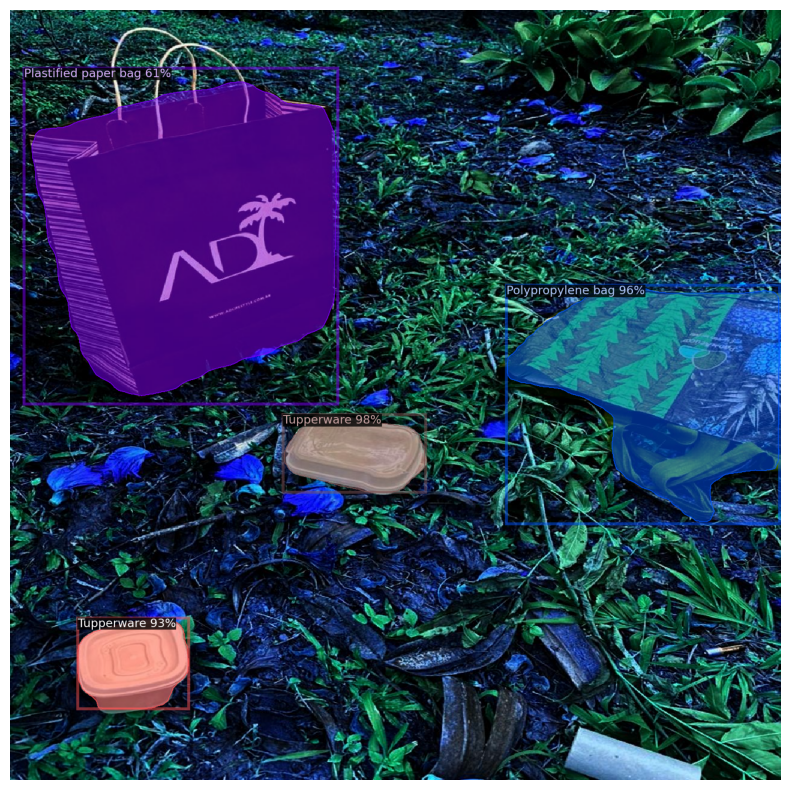

In [126]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10))
plt.imshow(out.get_image()[:, :, ::-1])
plt.axis("off")
plt.show()


There is an endless scope to improve the performance of a computer vision model. Feel free to further enhance. Good luck with your fine-tuning!